In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from hpa_src.config import get_data_dir, name_label_dict
from hpa_src.data.datasets import readimg, HpaDataset, TestDataset, train_val_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

DATA = get_data_dir()

In [3]:
from torch.utils.data import DataLoader, random_split
from PIL import Image
from torchvision import transforms
from hpa_src.data.transforms import ToPIL, ToNumpy
from hpa_src.data.functional import iterable_cycle
import torch

In [4]:
image_df = pd.read_csv(DATA + "raw/png/train.csv")

In [5]:
input_size = 299
train_transform = transforms.Compose([
    ToPIL(),
    #transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.1149, 0.0922, 0.0553),
                         (0.1694, 0.1381, 0.1551)),
    ToNumpy()
])
val_transform = transforms.Compose([
    ToPIL(),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.1149, 0.0922, 0.0553),
                         (0.1694, 0.1381, 0.1551)),
    ToNumpy()
])

In [6]:
train_sampler, val_sampler = train_val_split(image_df.shape[0])

In [7]:
train_dataset = HpaDataset(DATA + 'raw/png/train.csv', transform=train_transform)
val_dataset = HpaDataset(DATA + 'raw/png/train.csv', transform=val_transform)

In [8]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, sampler=train_sampler,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, sampler=val_sampler,
    num_workers=16
)

dataloaders = {'train': iterable_cycle(train_loader), 'val': iterable_cycle(val_loader)}

## Build model

In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Input, Conv2D
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score
from hpa_src.models.metrics import f1
from keras.optimizers import Adam 

Using TensorFlow backend.


In [10]:
epochs = 10; batch_size = 16
checkpoint = ModelCheckpoint(DATA+'../models/InceptionV3.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [12]:
model = create_model(
    input_shape=(input_size,input_size,3), 
    n_out=28)

In [13]:
for layer in model.layers:
    layer.trainable = False
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True

In [14]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(1e-03),
    metrics=[f1])

In [ ]:
model.fit_generator(
    dataloaders['train'],
    steps_per_epoch=np.ceil(float(len(train_sampler.indices)) / float(batch_size)),
    validation_data=dataloaders['val'],
    validation_steps=np.ceil(float(len(val_sampler.indices)) / float(batch_size)),
    epochs=3, 
    verbose=1,
    callbacks=[early])

In [ ]:
# resume training
model = load_model('../models/InceptionV3.h5', custom_objects={'f1': f1})

In [ ]:
for layer in model.layers:
    layer.trainable = True
model.compile(loss='binary_crossentropy',
            optimizer=Adam(lr=1e-4),
            metrics=[f1])
model.fit_generator(
    dataloaders['train'],
    steps_per_epoch=np.ceil(float(len(train_sampler.indices)) / float(batch_size)),
    validation_data=dataloaders['val'],
    validation_steps=np.ceil(float(len(val_sampler.indices)) / float(batch_size)),
    epochs=100, 
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/100
1554/1554 [==============================] - 11330s 7s/step - loss: 0.1096 - f1: 0.1768 - val_loss: 0.1006 - val_f1: 0.2008

Epoch 00001: val_loss improved from inf to 0.10061, saving model to /data/nasif12/home_if12/chengju/project/HumanProteinAtlas/hpa_src/../data/../models/InceptionV3.h5
Epoch 2/100
1554/1554 [==============================] - 11836s 8s/step - loss: 0.1082 - f1: 0.1822 - val_loss: 0.1081 - val_f1: 0.1959

Epoch 00002: val_loss did not improve from 0.10061
Epoch 3/100
1554/1554 [==============================] - 11686s 8s/step - loss: 0.1068 - f1: 0.1852 - val_loss: 0.1051 - val_f1: 0.2004

Epoch 00003: val_loss did not improve from 0.10061
Epoch 4/100
1554/1554 [==============================] - 11502s 7s/step - loss: 0.1052 - f1: 0.1905 - val_loss: 0.1044 - val_f1: 0.2013

Epoch 00004: val_loss did not improve from 0.10061

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 5/100
  71/1554 [>...........................

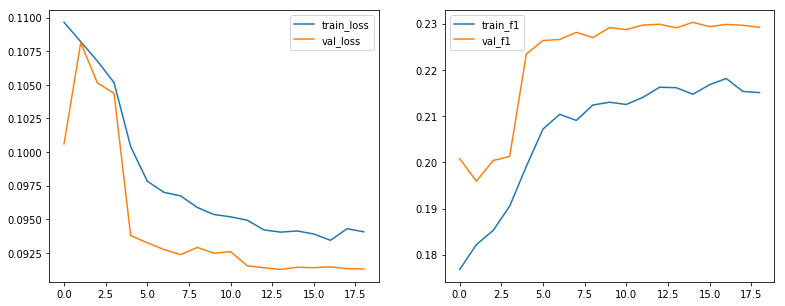

In [21]:
# plt.subplot(121)
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax1.plot(model.history.epoch, model.history.history['loss'], label='train_loss')
ax1.plot(model.history.epoch, model.history.history['val_loss'], label='val_loss')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(model.history.epoch, model.history.history['f1'], label='train_f1')
ax2.plot(model.history.epoch, model.history.history['val_f1'], label='val_f1')
ax2.legend()
plt.show()